In [1]:
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+

from pyspark.sql import SparkSession, functions, types
from pyspark.sql.functions import udf
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev,stddev_pop,avg,max,to_timestamp
from pyspark.sql import Window
spark = SparkSession.builder.appName('eda elevator').getOrCreate()
assert spark.version >= '2.4' # make sure we have Spark 2.4+
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

In [2]:
 data_schema = types.StructType([
    types.StructField('Timestamp', types.StringType()),
    types.StructField('AccelerationX', types.DoubleType()),
    types.StructField('AccelerationY', types.DoubleType()),
    types.StructField('AccelerationZ', types.DoubleType())
    ])

In [3]:
df = spark.read.csv("/home/riat/sfuhome/EDS_8.csv/EDS_8.csv",schema=data_schema)

In [4]:
df_filter = df.where((df['Timestamp']>='2018-07-09 12:00:00') & (df['Timestamp']<='2018-08-09 12:00:00'))

In [5]:
df_filter = df_filter.select(df_filter['Timestamp'],(-1 * df_filter['AccelerationX']).alias("AccelerationX"))
#df_filter = df_filter.withColumnRenamed("- AccelerationZ", "AccelerationZ")

In [6]:
# Apply Z- Normalization 

unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["AccelerationX"],
    outputCol="Xvector")
tempdata = assembler.transform(df_filter)
scaler = StandardScaler(inputCol="Xvector", outputCol="Xscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Xscale", unlist("Xscale")).drop("Xvector").cache()

In [7]:
# Strip the timestamp to seconds
scaledData = scaledData.withColumn("Timestamp1", to_timestamp("Timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()


In [8]:
movAvg = scaledData.withColumn("movingAverage", functions.avg(scaledData["Xscale"])
             .over(Window.partitionBy(scaledData["timestamp1"]).rowsBetween(-1,1))).cache()

In [9]:
find_mode = scaledData.withColumn("Frequency", functions.round(scaledData["Xscale"], 0))

In [10]:
count_zscale = find_mode.groupby(find_mode['Frequency']).count()

In [ ]:
count_zscale.toPandas().to_csv('/home/riat/sfuhome/EDA8_frequency.csv')

In [58]:
find_sample = find_mode.where(find_mode['Frequency']==10)
#| (functions.round(scaledData["Zscale"], 1)==-37.7)) 
find_sample.show()

+--------------------+-------------+---------+-------------------+---------+
|           Timestamp|AccelerationX|   Xscale|         Timestamp1|Frequency|
+--------------------+-------------+---------+-------------------+---------+
|2018-07-09 12:09:...|     1.027344| 9.627142|2018-07-09 12:09:37|     10.0|
|2018-07-09 12:09:...|     1.027344| 9.627142|2018-07-09 12:09:37|     10.0|
|2018-07-09 12:09:...|      1.03125|10.446249|2018-07-09 12:09:37|     10.0|
|2018-07-09 12:09:...|      1.03125|10.446249|2018-07-09 12:09:37|     10.0|
|2018-07-09 12:09:...|     1.027344| 9.627142|2018-07-09 12:09:37|     10.0|
|2018-07-09 12:09:...|     1.027344| 9.627142|2018-07-09 12:09:37|     10.0|
|2018-07-09 12:14:...|     1.027344| 9.627142|2018-07-09 12:14:17|     10.0|
|2018-07-09 12:14:...|     1.027344| 9.627142|2018-07-09 12:14:17|     10.0|
|2018-07-09 12:14:...|      1.03125|10.446249|2018-07-09 12:14:18|     10.0|
|2018-07-09 12:15:...|      1.03125|10.446249|2018-07-09 12:15:41|     10.0|

### Anomaly 1 

In [11]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Xscale from scaledData where Timestamp1 between '2018-07-20 19:44:00' and '2018-07-20 19:44:50' ''')

CPU times: user 207 ms, sys: 43 ms, total: 250 ms
Wall time: 5min 39s


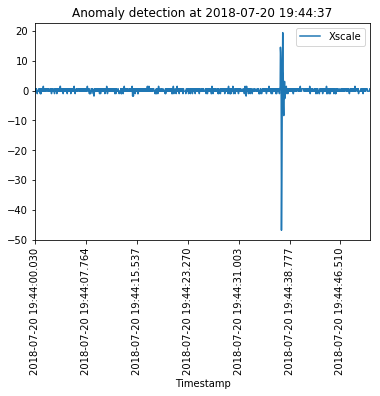

In [12]:
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%matplotlib inline
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Xscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-20 19:44:37')
plt.rcParams["figure.figsize"] = [10, 5]

In [13]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-20 19:44:00' and '2018-07-20 19:44:50' ''')

CPU times: user 129 ms, sys: 11.7 ms, total: 141 ms
Wall time: 1min 4s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-12 10:25:57')

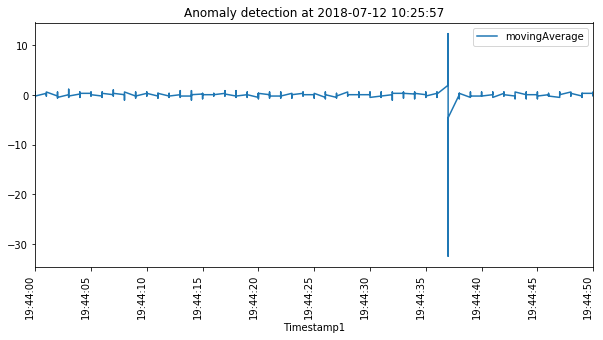

In [14]:
# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-12 10:25:57')

### Anomaly 2

In [19]:
df_check = spark.sql('''select Timestamp, Timestamp1, Xscale from scaledData where Timestamp1 between '2018-07-20 19:44:00' and '2018-07-20 19:44:55' ''')

CPU times: user 116 ms, sys: 3.66 ms, total: 120 ms
Wall time: 23.4 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-20 19:44:37')

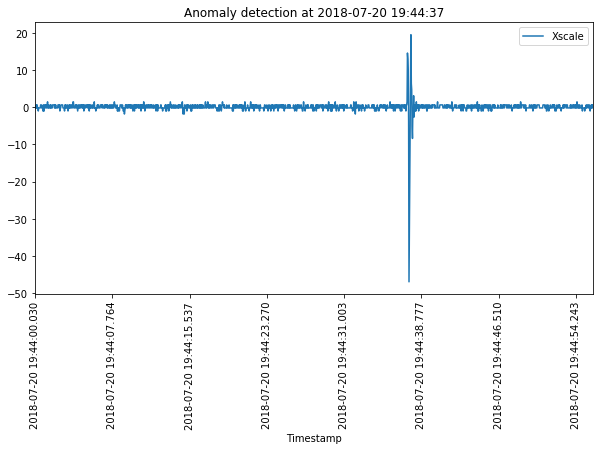

In [20]:
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Xscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-20 19:44:37')

In [16]:
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-20 19:44:00' and '2018-07-20 19:44:55' ''')

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 23.7 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-20 19:44:37')

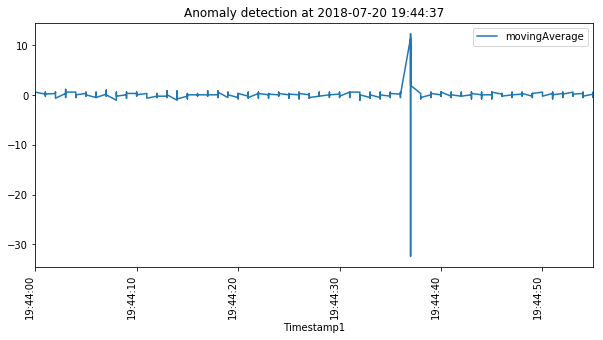

In [17]:
# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-20 19:44:37')

### Anomaly 3

In [22]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Xscale from scaledData where Timestamp1 between '2018-07-26 11:54:00' and '2018-07-26 11:55:00' ''')

CPU times: user 126 ms, sys: 827 µs, total: 127 ms
Wall time: 22 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-26 11:54:55')

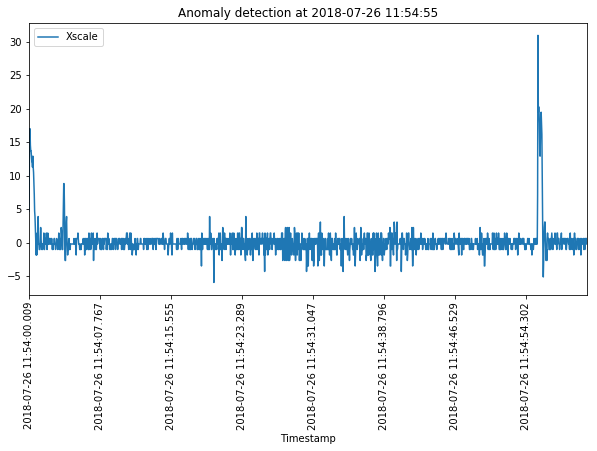

In [23]:
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Xscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-26 11:54:55')

In [24]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-26 11:54:00' and '2018-07-26 11:55:00' ''')

CPU times: user 144 ms, sys: 13.7 ms, total: 157 ms
Wall time: 21.7 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-26 11:54:55')

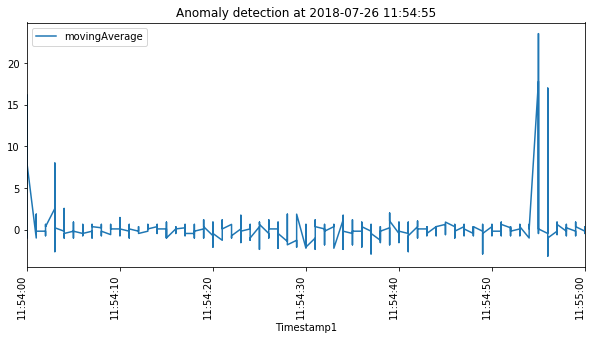

In [25]:
# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-26 11:54:55')

### Anomaly 4 

In [27]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Xscale from scaledData where Timestamp1 between '2018-07-16 09:27:10' and '2018-07-16 09:27:55' ''')

CPU times: user 97.9 ms, sys: 4.42 ms, total: 102 ms
Wall time: 25 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-16 09:27:48')

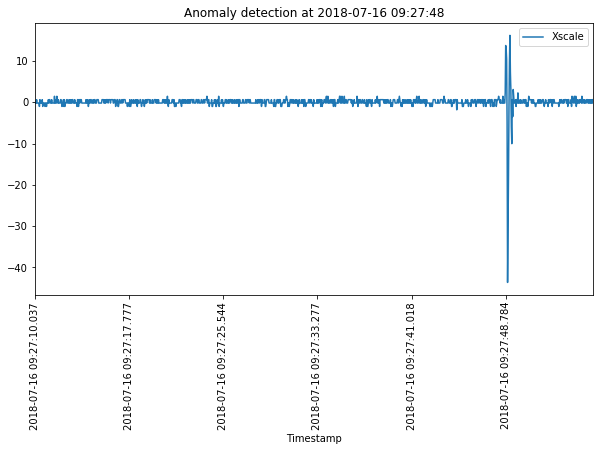

In [29]:
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Xscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-16 09:27:48')

In [30]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-16 09:27:10' and '2018-07-16 09:27:55' ''')


CPU times: user 136 ms, sys: 4.56 ms, total: 141 ms
Wall time: 25.6 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-16 09:27:48')

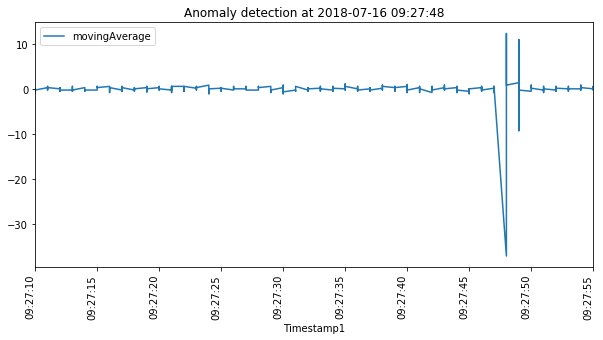

In [31]:
# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-16 09:27:48')

### Anomaly 5

CPU times: user 74.3 ms, sys: 3.74 ms, total: 78 ms
Wall time: 27.6 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-12 12:53:47')

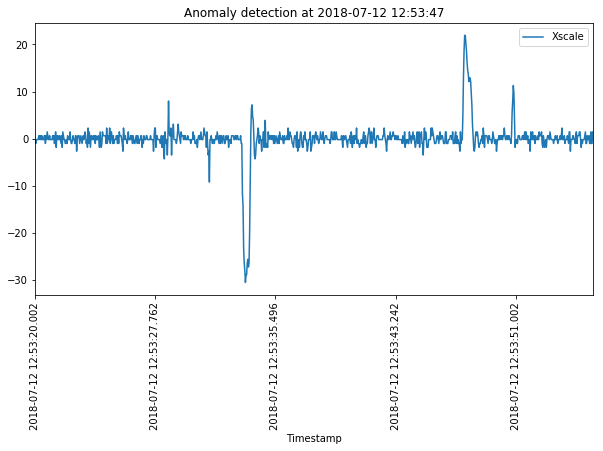

In [33]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Xscale from scaledData where Timestamp1 between '2018-07-12 12:53:20' and '2018-07-12 12:53:55' ''')
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Xscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-12 12:53:47')




CPU times: user 92.9 ms, sys: 0 ns, total: 92.9 ms
Wall time: 26.4 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-23 17:51:39')

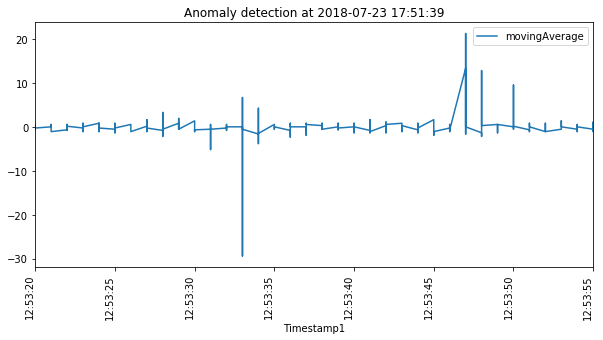

In [34]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-12 12:53:20' and '2018-07-12 12:53:55' ''')

# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-23 17:51:39')

From dates 2018-07-16 12:00:00 to 2018-07-24 12:00:00

### Anomaly 6

CPU times: user 83.9 ms, sys: 7.64 ms, total: 91.5 ms
Wall time: 22.2 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-27 12:36:03')

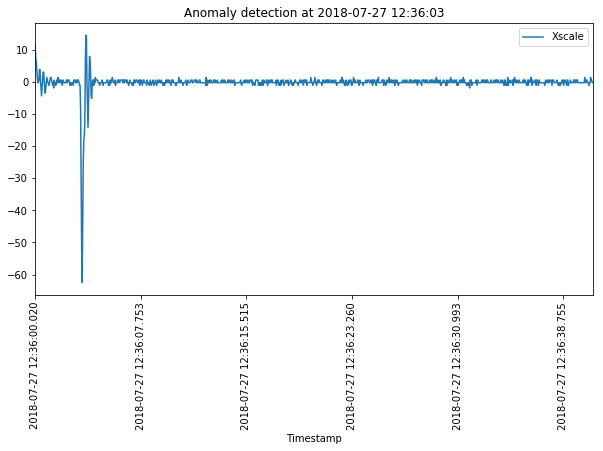

In [36]:

scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Xscale from scaledData where Timestamp1 between '2018-07-27 12:36:00' and '2018-07-27 12:36:40' ''')
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Xscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-27 12:36:03')

CPU times: user 108 ms, sys: 4.48 ms, total: 112 ms
Wall time: 22 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-27 12:36:03')

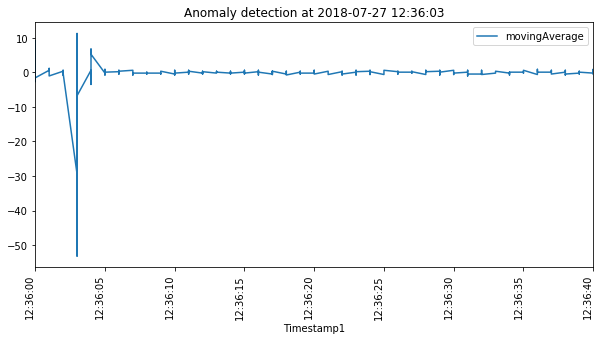

In [37]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-27 12:36:00' and '2018-07-27 12:36:40' ''')

# Convert to Pandas and plot

%time temp_pandas2 = df_check_mov.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-27 12:36:03')

### Anomaly 7

CPU times: user 110 ms, sys: 0 ns, total: 110 ms
Wall time: 27.8 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-16 15:54:37')

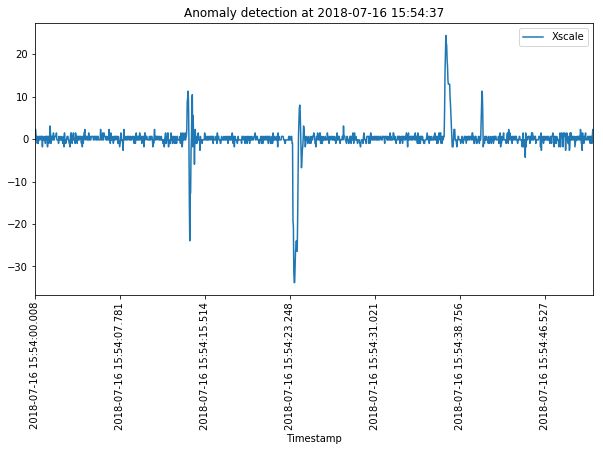

In [39]:

scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Xscale from scaledData where Timestamp1 between '2018-07-16 15:54:00' and '2018-07-16 15:54:50' ''')
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Xscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-16 15:54:37')

CPU times: user 110 ms, sys: 12.3 ms, total: 122 ms
Wall time: 28.2 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-16 15:54:37')

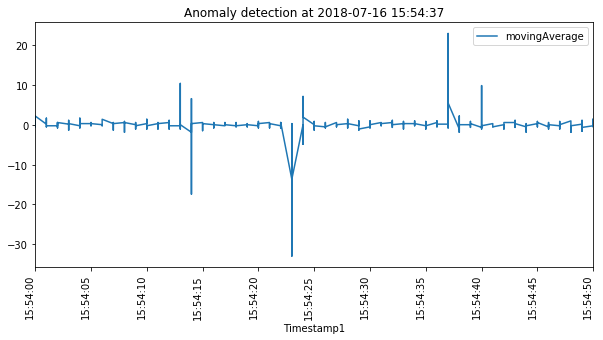

In [40]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-16 15:54:00' and '2018-07-16 15:54:50' ''')

# Convert to Pandas and plot

%time temp_pandas2 = df_check_mov.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-16 15:54:37')

### Anomaly 8

CPU times: user 86.6 ms, sys: 59 µs, total: 86.6 ms
Wall time: 24.3 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-19 20:23:01')

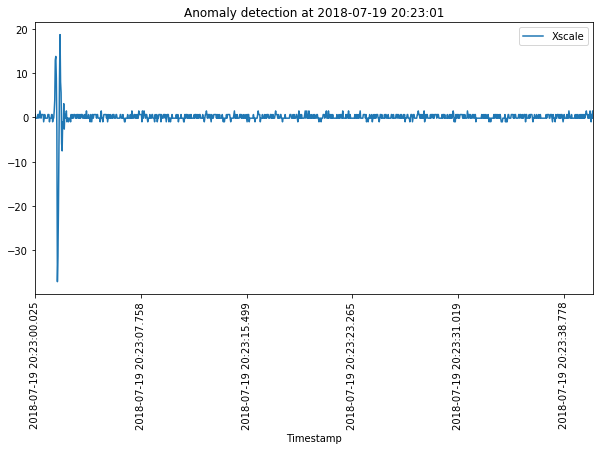

In [42]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Xscale from scaledData where Timestamp1 between '2018-07-19 20:23:00' and '2018-07-19 20:23:40' ''')
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Xscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-19 20:23:01')

CPU times: user 99.8 ms, sys: 3.91 ms, total: 104 ms
Wall time: 24.2 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-19 20:23:01')

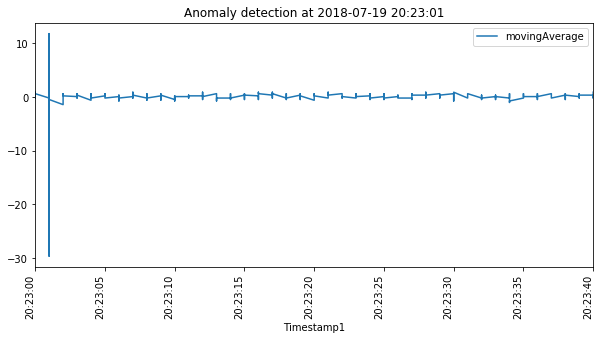

In [43]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-19 20:23:00' and '2018-07-19 20:23:40' ''')

# Convert to Pandas and plot

%time temp_pandas2 = df_check_mov.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-19 20:23:01')

### Anomaly 9 

CPU times: user 102 ms, sys: 3.78 ms, total: 106 ms
Wall time: 24.2 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-17 19:17:12')

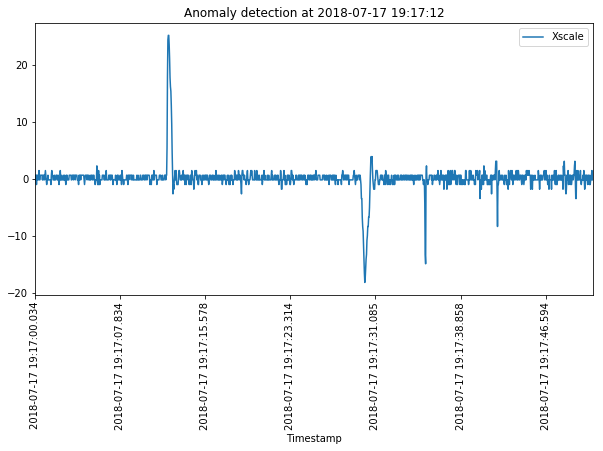

In [45]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Xscale from scaledData where Timestamp1 between '2018-07-17 19:17:00' and '2018-07-17 19:17:50' ''')
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Xscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-17 19:17:12')

CPU times: user 109 ms, sys: 12.5 ms, total: 122 ms
Wall time: 25.3 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-17 19:17:12')

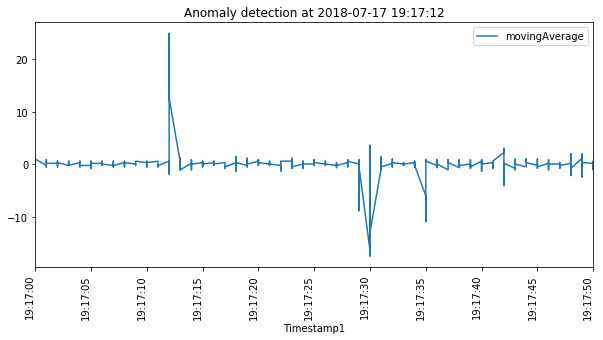

In [46]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-17 19:17:00' and '2018-07-17 19:17:50' ''')

# Convert to Pandas and plot

%time temp_pandas2 = df_check_mov.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-17 19:17:12')

### Anomaly 10

CPU times: user 87 ms, sys: 0 ns, total: 87 ms
Wall time: 17.2 s


Text(0.5, 1.0, 'Anomaly detection at 2018-08-05 02:48:13')

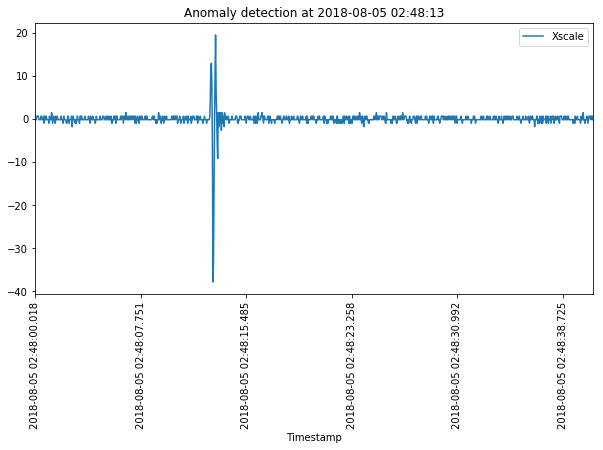

In [48]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Xscale from scaledData where Timestamp1 between '2018-08-05 02:48:00' and '2018-08-05 02:48:40' ''')
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Xscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-08-05 02:48:13')

CPU times: user 140 ms, sys: 4.18 ms, total: 144 ms
Wall time: 17.7 s


Text(0.5, 1.0, 'Anomaly detection at 2018-08-05 02:48:13')

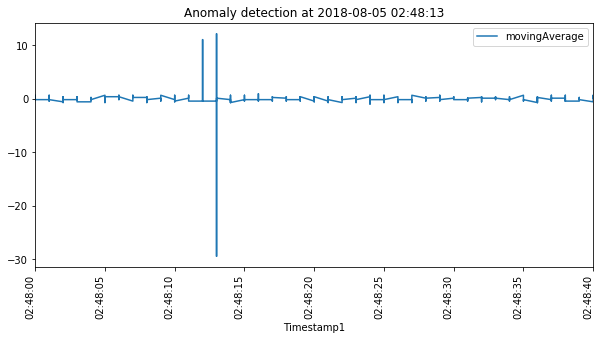

In [49]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-08-05 02:48:00' and '2018-08-05 02:48:40' ''')

# Convert to Pandas and plot

%time temp_pandas2 = df_check_mov.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-08-05 02:48:13')

### Normal peaks

CPU times: user 34.5 ms, sys: 145 µs, total: 34.6 ms
Wall time: 27.3 s


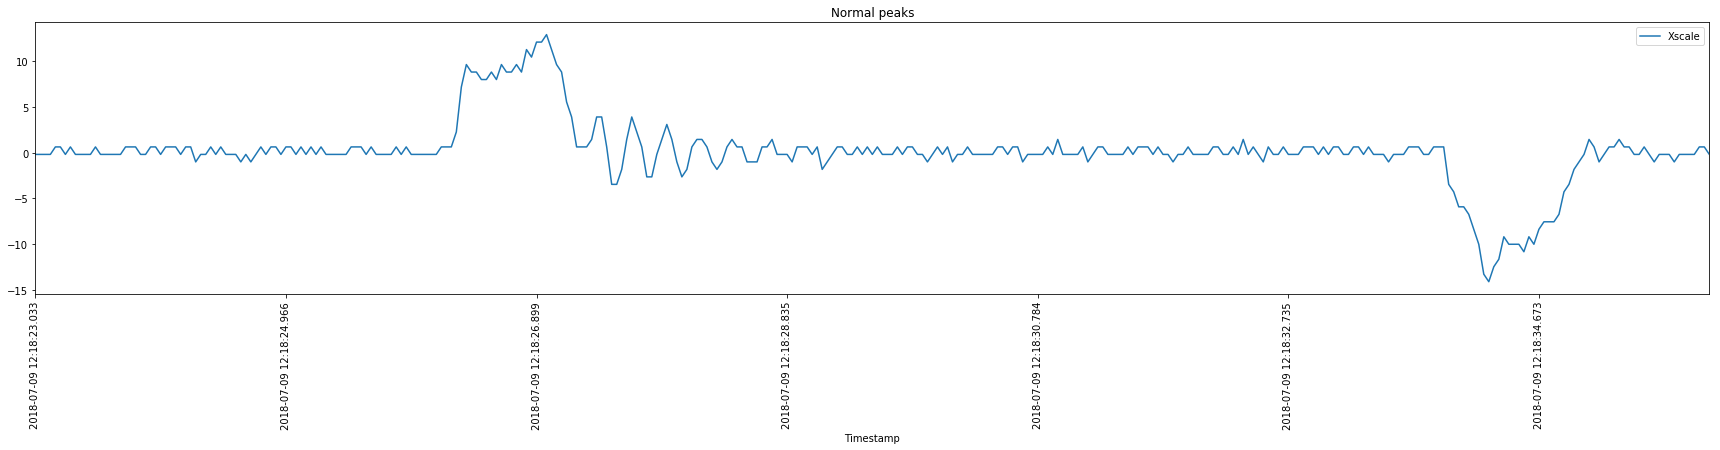

In [52]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Xscale from scaledData where Timestamp1 between '2018-07-09 12:18:23' and '2018-07-09 12:18:35' ''')

# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Xscale', kind = 'line',rot=90)
plt.title('Normal peaks')

plt.rcParams["figure.figsize"] = [30, 5]

CPU times: user 82.6 ms, sys: 3.89 ms, total: 86.5 ms
Wall time: 27.2 s


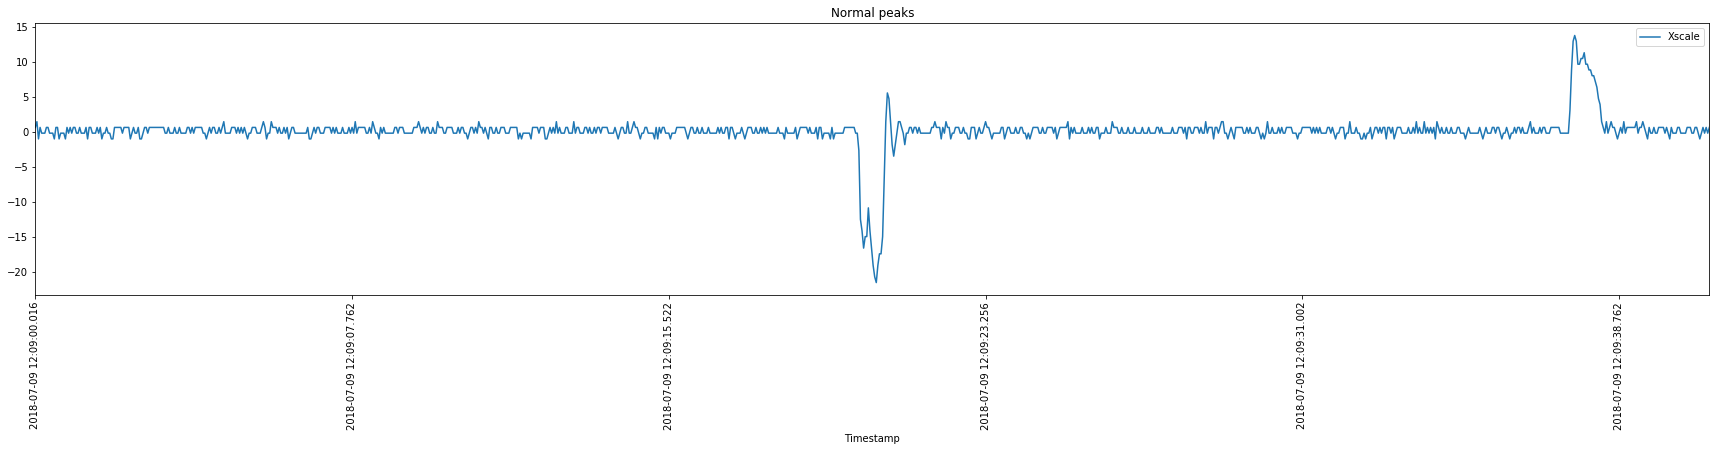

In [59]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Xscale from scaledData where Timestamp1 between '2018-07-09 12:09:00' and '2018-07-09 12:09:40' ''')

# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Xscale', kind = 'line',rot=90)
plt.title('Normal peaks') 

plt.rcParams["figure.figsize"] = [30, 5]